## Big Data Platforms - Winter 2023
## Final Project Education

### Twitterer Profile Analysis

#### Minh Vo

In [1]:
import os
import time
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
# import sh
from pyspark.sql.functions import *
from pyspark.sql.types import *
from itertools import compress

from pyspark.sql.functions import date_format, to_timestamp, unix_timestamp, from_unixtime
from pyspark.sql.functions import split

pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
warnings.filterwarnings(action='ignore')

In [2]:
from google.cloud import storage

In [3]:
!hadoop fs -ls "gs://msca-bdp-students-bucket/shared_data/mdvo/BDP-Final-Project" | head -10

Found 5742 items
-rwx------   3 root root          0 2023-03-09 07:30 gs://msca-bdp-students-bucket/shared_data/mdvo/BDP-Final-Project/_SUCCESS
-rwx------   3 root root    2605946 2023-03-09 07:14 gs://msca-bdp-students-bucket/shared_data/mdvo/BDP-Final-Project/part-00000-59df6c97-c835-4c6d-8159-1dfe42cf74f5-c000.snappy.parquet
-rwx------   3 root root    2855860 2023-03-09 07:14 gs://msca-bdp-students-bucket/shared_data/mdvo/BDP-Final-Project/part-00001-59df6c97-c835-4c6d-8159-1dfe42cf74f5-c000.snappy.parquet
-rwx------   3 root root    2960462 2023-03-09 07:14 gs://msca-bdp-students-bucket/shared_data/mdvo/BDP-Final-Project/part-00002-59df6c97-c835-4c6d-8159-1dfe42cf74f5-c000.snappy.parquet
-rwx------   3 root root    2707638 2023-03-09 07:14 gs://msca-bdp-students-bucket/shared_data/mdvo/BDP-Final-Project/part-00003-59df6c97-c835-4c6d-8159-1dfe42cf74f5-c000.snappy.parquet
-rwx------   3 root root    3077704 2023-03-09 07:14 gs://msca-bdp-students-bucket/shared_data/mdvo/BDP-Final-Pr

### Data Loading

In [4]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [6]:
%%time
mypath = "gs://msca-bdp-students-bucket/shared_data/mdvo/BDP-Final-Project"
twt_newdf = spark.read.parquet(mypath)
twt_newdf.limit(5)

CPU times: user 0 ns, sys: 5.01 ms, total: 5.01 ms
Wall time: 1.14 s


coordinates,favorite_count,filter_level,in_reply_to_screen_name,retweeted,retweet_count,retweeted_from,retweeted_status,text,country,country_code,full_name,place_type,bounding_box,timestamp_ms,id_str,name,screen_name,location,description,followers_count,statuses_count,created_at,verified,lang
null,0,low,null,RT,0,imillhiser,"{null, Mon Apr 25...",RT @imillhiser: L...,null,null,null,null,null,1650908748129,1638422174,Amos Burton 🌻🇺🇦🪆,Bellarusque,rent free in your...,"""First of all, I ...",64,195316,Thu Aug 01 17:06:...,false,en
null,0,low,null,RT,0,BenIrvineAuthor,"{null, Mon Apr 25...",RT @BenIrvineAuth...,null,null,null,null,null,1650908749742,883407625714634752,KJV ✝️🇬🇧,KJVBaptist193,"London, England.",Imperfect #Christ...,11877,126224,Fri Jul 07 19:29:...,false,en
null,0,low,null,RT,0,MelanieMse,"{null, Mon Apr 25...",RT @MelanieMse: H...,null,null,null,null,null,1650908750704,1383730953361625089,"Cats, Kids, Chaos",catskidschaos,"Richmond, London",Sharing London tw...,1018,7544,Sun Apr 18 10:35:...,false,en
null,0,low,null,RT,0,jk_rowling,"{null, Mon Apr 25...",RT @jk_rowling: I...,null,null,null,null,null,1650908750966,1070744322058936321,Urbas Michèle,MicheleUrbas,null,null,15,1431,Thu Dec 06 18:18:...,false,en
null,0,low,null,RT,0,joeyhiles1,"{null, Sun Apr 24...",RT @joeyhiles1: W...,null,null,null,null,null,1650908753102,868642741332455424,quentin quarantino,sweetlizardtail,null,V | they/them | 2...,66,48501,Sun May 28 01:39:...,false,en


In [ ]:
twt_newdf.count()

24721729

In [ ]:
#twt_newdf.describe().show()

In [7]:
twt_newdf.columns

['coordinates',
 'favorite_count',
 'filter_level',
 'in_reply_to_screen_name',
 'retweeted',
 'retweet_count',
 'retweeted_from',
 'retweeted_status',
 'text',
 'country',
 'country_code',
 'full_name',
 'place_type',
 'bounding_box',
 'timestamp_ms',
 'id_str',
 'name',
 'screen_name',
 'location',
 'description',
 'followers_count',
 'statuses_count',
 'created_at',
 'verified',
 'lang']

In [ ]:
twt_newdf2 = twt_newdf.select('retweet_count','bounding_box','followers_count','verified','description','text','lang','retweeted_status','created_at')
twt_newdf2.describe()

summary,retweet_count,followers_count,description,text,lang,created_at
count,24721729,24721729,20167284,24721729,24721729,24721729
mean,0.0,8055.355479788651,NaN,null,null,null
stddev,0.0,271266.154528689,NaN,null,null,null
min,0,-1,!,! Check out this...,en,Fri Apr 01 00:00:...
max,0,122849058,󾓪 // ☭ //🏺,🫶🏾all my senior...,en,Wed Sep 30 23:59:...


### Analysis

#### Identify the most prolific / influential Twitterers:

In [9]:
%%time 

# List of Twitterers and their screen names
user_df = twt_newdf.groupBy('id_str').agg(max('screen_name').alias('user_name'))
user_df.show(10)

+-------------------+--------------+
|             id_str|     user_name|
+-------------------+--------------+
|1000006405380812800|annoyingsoul29|
|1000006420299898880|       ainiwhy|
|1000011951274123269|     stelexies|
|1000015310651645953|    PhilStudge|
|          100001851| alqamaronline|
|1000026245508329472|    MNBlankson|
|1000026471044407296|     HeadUnity|
|1000027408508977152|     SaigonSte|
|1000040355209793536|  gimbapgoogie|
|1000040400810323969|      xShadiku|
+-------------------+--------------+
only showing top 10 rows

CPU times: user 195 ms, sys: 47.2 ms, total: 242 ms
Wall time: 1min 16s


In [ ]:
%%time

# twitterers by number of followers
followers_df = twt_newdf.groupBy('id_str','screen_name')\
                        .agg(max('followers_count').alias('Total_Followers'))\
                        .orderBy('Total_Followers',ascending = False)
followers_df.show(10)

+--------+------------+---------------+
|  id_str| screen_name|Total_Followers|
+--------+------------+---------------+
|44196397|    elonmusk|      122849058|
|21447363|   katyperry|      108899882|
|18839785|narendramodi|       83552404|
|10228272|     YouTube|       77788673|
|23375688| selenagomez|       65889944|
|11348282|        NASA|       64878725|
|  428333|      cnnbrk|       64160677|
|  759251|         CNN|       61104555|
|  807095|     nytimes|       54936969|
| 5402612| BBCBreaking|       51529913|
+--------+------------+---------------+
only showing top 10 rows

CPU times: user 150 ms, sys: 30.4 ms, total: 181 ms
Wall time: 57.4 s


In [7]:
# twitterers by number of followers
followers_df = twt_newdf.groupBy('id_str','screen_name')\
                        .agg(max('followers_count').alias('Total_Followers'))\
                        .orderBy('Total_Followers',ascending = False)
followers_df.show(10)

+--------+------------+---------------+
|  id_str| screen_name|Total_Followers|
+--------+------------+---------------+
|44196397|    elonmusk|      122849058|
|21447363|   katyperry|      108899882|
|18839785|narendramodi|       83552404|
|10228272|     YouTube|       77788673|
|23375688| selenagomez|       65889944|
|11348282|        NASA|       64878725|
|  428333|      cnnbrk|       64160677|
|  759251|         CNN|       61104555|
|  807095|     nytimes|       54936969|
| 5402612| BBCBreaking|       51529913|
+--------+------------+---------------+
only showing top 10 rows



##### By message volume (original content)

In [6]:
## Original contents imply tweets which are not retweets (retweeted_status = null)
twt_newdf = twt_newdf.withColumn('is_original_twt',when(col('retweeted_status.retweeted').isNull(), 1).otherwise(0))

In [7]:
%%time
twitterer_groups = twt_newdf.withColumn('Twitterer_Group', \
           when((twt_newdf.verified==True) & (lower(col('name')).contains('college')),'Universities').\
           when((twt_newdf.verified==True) & (lower(col('name')).contains('university')), 'Universities').\
           when((twt_newdf.verified==True) & (lower(col('name')).contains('school')), 'Schools').\
           when((twt_newdf.verified==True) & (lower(col('description')).contains('government')),'Government Entities').\
           when((twt_newdf.verified==True) & (lower(col('description')).contains('news') | lower(col('description')).contains('magazine')),'News Outlets').\
           when((twt_newdf.verified==True) & (lower(col('description')).contains('organization') | lower(col('description')).contains('organization')),'Non-Profit Organizations').\
           when((twt_newdf.verified==True) & (lower(col('description')).contains('non-profit')),'Non-Profit Organizations').\
           when((twt_newdf.verified==True) & ((twt_newdf.followers_count > 5000) | (lower(col('description')).contains('influencer'))),'Social Media Influencers').\
           otherwise('Others'))

CPU times: user 18.6 ms, sys: 7.62 ms, total: 26.2 ms
Wall time: 347 ms


In [ ]:
twitterer_groups.groupby('Twitterer_Group').count().orderBy("count",ascending=False).toPandas()

,Twitterer_Group,count
0,Others,24343776
1,Social Media Influencers,226766
2,News Outlets,127342
3,Universities,9641
4,Schools,6209
5,Government Entities,5067
6,Non-Profit Organizations,2928


In [9]:
# Save the output
save_path = 'gs://msca-bdp-students-bucket/shared_data/mdvo/BDP-Final/User-Groups'
twitterer_groups.write.format('parquet').\
            mode('overwrite').\
            save(save_path)

In [52]:
%%time
## Find the number of original tweets by users (apply not null filter on description)
original_tweets = twitterer_groups.filter(col('description').isNotNull())\
                             .groupBy('screen_name','Twitterer_Group','description')\
                                      .agg(sum("is_original_twt").alias("Total_Original_Tweets"),\
                                           max('followers_count').alias('Total_Followers'))\
                                      .orderBy("Total_Original_Tweets",ascending=False)
original_tweets.limit(10)

CPU times: user 0 ns, sys: 11.6 ms, total: 11.6 ms
Wall time: 141 ms


screen_name,Twitterer_Group,description,Total_Original_Tweets,Total_Followers
SexualAssaultB2,Others,Raising awareness...,4551,22
sportsthread,Social Media Infl...,‼️Sports Thread i...,3148,206502
ParentSecurity,Others,#Parents who want...,2362,301
CSAPrepStar,Others,Got Game? Get Rec...,2273,68155
onepostguy,Others,I am not a bot be...,2143,123
Porxlek1,Others,.,2095,0
group_kq,Others,THIS WEBSITE PROV...,1780,199
BVEvery,Others,"GA, TN, VA, WV S...",1777,8323
AgadirGroup,Others,Welcome to AGADIR...,1722,103
abby_turner622,Others,A bot who needs l...,1629,35


<AxesSubplot:title={'center':'Top 10 Users by Total Original Tweets'}, ylabel='screen_name'>

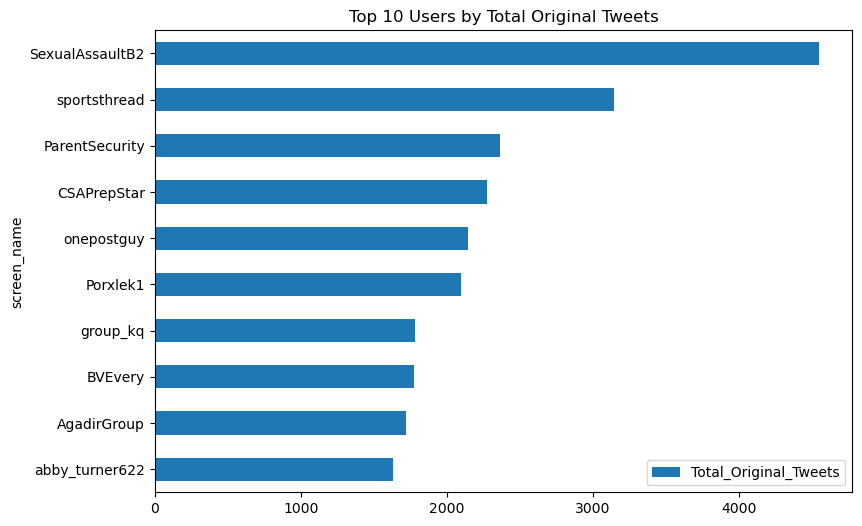

In [22]:
# # plot original twts
# original_df_plot = original_tweets.limit(10).toPandas()
# original_df_plot.sort_values('Total_Original_Tweets',inplace=True)
# original_df_plot.plot(kind='barh', x='screen_name', y='Total_Original_Tweets', figsize=(8,6), title="Top 10 Users by Total Original Tweets")

##### By message retweet (how often their messages are being retweeted)

In [ ]:
%%time

#by twitterers (who have high number of tweets being retweeted)
retweeted_user = twitterer_groups.filter(twt_newdf.retweeted_status.isNotNull())\
                        .groupBy('retweeted_from','Twitterer_Group')\
                        .agg(sum('retweeted_status.retweet_count').alias('Total_Retweets'),\
                             max('followers_count').alias('Total_Followers'))\
                        .orderBy('Total_Retweets',ascending = False)
retweeted_user.limit(10)

CPU times: user 4.98 ms, sys: 7.87 ms, total: 12.8 ms
Wall time: 119 ms


retweeted_from,Twitterer_Group,Total_Retweets,Total_Followers
PEScorpiio,Others,1595534088,345186
NicholasFerroni,Others,1495469654,202283
itsmestacyz,Others,1144297406,67211
NasimiShabnam,Others,1065018547,533689
AOC,Others,636188634,168573
elonmusk,Others,623136488,554636
Mr_JCE,Others,615883493,760187
Ernie_Zuniga,Others,500188211,824459
KianSharifi,Others,488854229,987453
javroar,Others,472114449,283557


<AxesSubplot:title={'center':'Top 10 Users by Total Retweeted Tweets'}, ylabel='retweeted_from'>

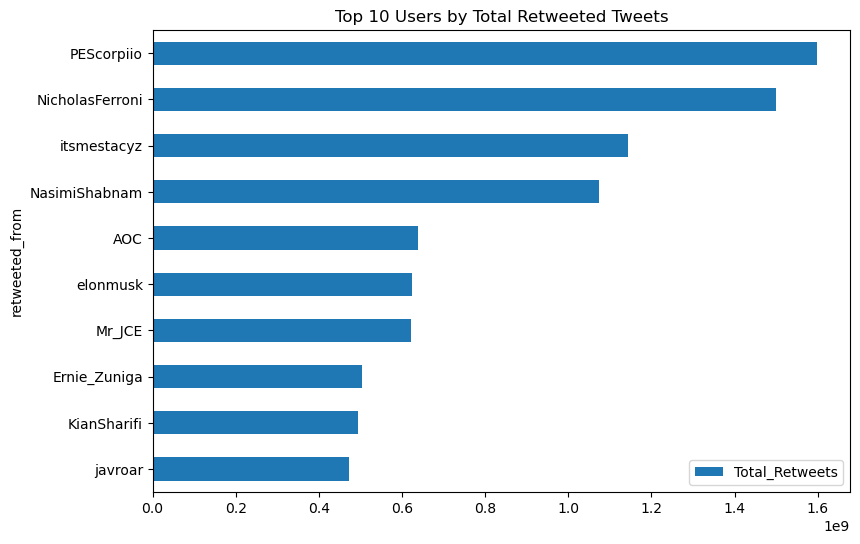

In [29]:
# plot retweets
retweets_df_plot = retweeted_user.limit(10).toPandas()
retweets_df_plot.sort_values('Total_Retweets',inplace=True)
retweets_df_plot.plot(kind='barh', x='retweeted_from', y='Total_Retweets', figsize=(9,6), title="Top 10 Users by Total Retweeted Tweets")

In [30]:
verified = twt_newdf.groupBy('verified').count().toPandas()
verified

,verified,count
0,True,431896
1,False,24289833


<AxesSubplot:xlabel='verified'>

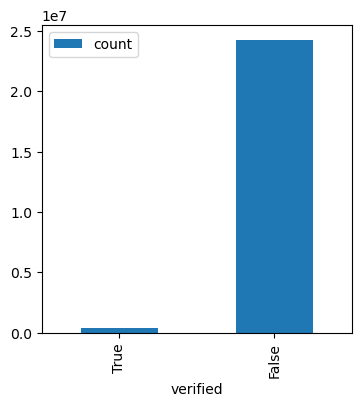

In [39]:
verified.plot.bar(x='verified',y='count',legend='verified',figsize=(4, 4))

In [8]:
# %%time
# twitterers_groups = twt_newdf.filter(col('verified')==True)\
# .withColumn('Twitterer_Group', \
#            when((twt_newdf.verified==True) & (lower(col('name')).contains('college')),'Universities').\
#            when((twt_newdf.verified==True) & (lower(col('name')).contains('university')), 'Universities').\
#            when((twt_newdf.verified==True) & (lower(col('name')).contains('school')), 'Schools').\
#            when((twt_newdf.verified==True) & (lower(col('description')).contains('government')),'Government Entities').\
#            when((twt_newdf.verified==True) & (lower(col('description')).contains('news') | lower(col('description')).contains('magazine')),'News Outlets').\
#            when((twt_newdf.verified==True) & (lower(col('description')).contains('organization') | lower(col('description')).contains('organization')),'Non-Profit Organizations').\
#            when((twt_newdf.verified==True) & lower(col('description')).contains('non-profit'),'Non-Profit Organizations').\
#            when((twt_newdf.verified==True) & (lower(col('description')).contains('influencer')) | (twt_newdf.followers_count > 5000),'Social Media Influencers').\
#            otherwise('Others'))

CPU times: user 19.8 ms, sys: 6.67 ms, total: 26.5 ms
Wall time: 406 ms


In [9]:
#table (count by group)
verified_group = twitterer_groups.filter(col('verified')==True)
verified_group.groupby('Twitterer_Group').count().orderBy("count",ascending=False).toPandas()

,Twitterer_Group,count
0,Social Media Influencers,226766
1,News Outlets,127342
2,Others,53943
3,Universities,9641
4,Schools,6209
5,Government Entities,5067
6,Non-Profit Organizations,2928


<AxesSubplot:title={'center':'Total Tweets by User Types'}, ylabel='Twitterer_Group'>

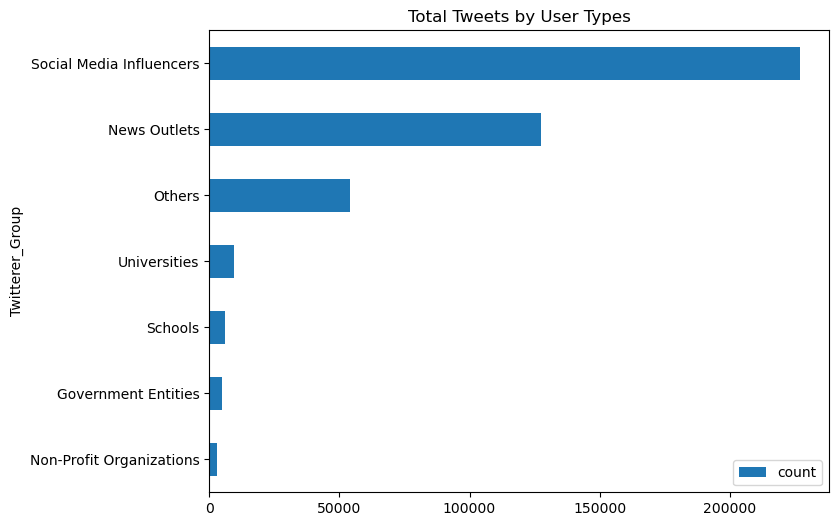

In [53]:
# tweets by types of orgs
twitterers_groups_plot = verified_group.groupby('Twitterer_Group').count().orderBy("count",ascending=True).toPandas()
twitterers_groups_plot.set
twitterers_groups_plot.plot(kind='barh', x='Twitterer_Group', y='count', figsize=(8,6),title="Total Tweets by User Types")

<AxesSubplot:title={'center':'Original Tweets by User Types'}, ylabel='Twitterer_Group'>

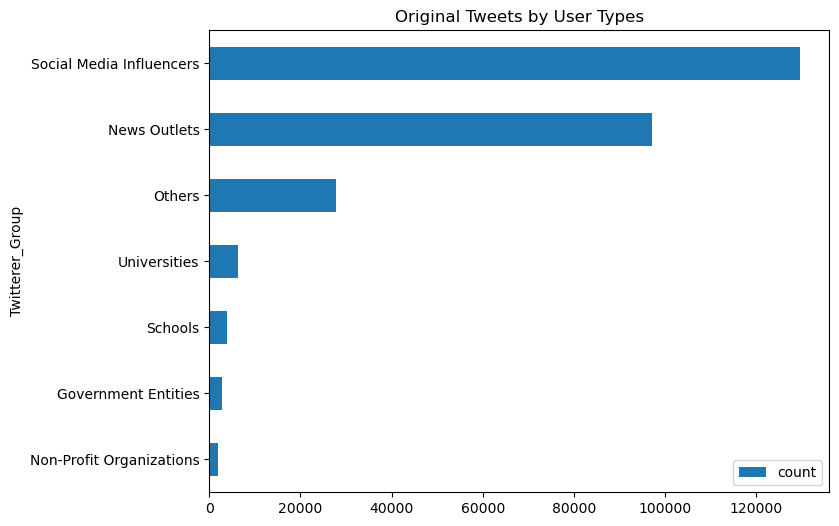

In [47]:
# Original Tweets by User groups plot
org_group_plot = verified_group.filter(col('retweeted')=="").groupBy('Twitterer_Group').count().orderBy('count',ascending=True).toPandas()
org_group_plot.plot(kind='barh', x='Twitterer_Group', y='count', figsize=(8,6),title="Original Tweets by User Types")

In [48]:
org_group_plot

,Twitterer_Group,count
0,Non-Profit Organizations,1943
1,Government Entities,2764
2,Schools,3852
3,Universities,6315
4,Others,27858
5,News Outlets,97064
6,Social Media Influencers,129513


In [49]:
# Original tweets by Tweeterers and types of Orgs

orgtwt_user_type = verified_group.groupBy('screen_name','Twitterer_Group')\
                        .agg(sum("is_original_twt").alias("Total_Original_Tweets"),\
                            max('followers_count').alias('Total_Followers'))\
                        .orderBy('Total_Original_Tweets',ascending = False)
orgtwt_user_type.limit(10).toPandas()

,screen_name,Twitterer_Group,Total_Original_Tweets,Total_Followers
0,sportsthread,Social Media Influencers,3148,206502
1,USNewsEducation,News Outlets,764,332591
2,timeshighered,News Outlets,726,317637
3,SF_England,Social Media Influencers,677,127004
4,TOICitiesNews,Social Media Influencers,636,27844
5,ExploreLearning,Social Media Influencers,576,9477
6,WashTimes,News Outlets,514,447359
7,SportsBookWire,Others,471,3847
8,tes,News Outlets,439,362347
9,DeAngelisCorey,Social Media Influencers,430,129470


In [50]:
# Retweets by User groups plot
retwt_group_plot = verified_group.filter(twitterers_groups.retweeted_status.isNotNull()).groupBy('Twitterer_Group').count().orderBy('count',ascending=True).toPandas()
retwt_group_plot

,Twitterer_Group,count
0,Non-Profit Organizations,985
1,Government Entities,2303
2,Schools,2357
3,Universities,3326
4,Others,26074
5,News Outlets,30274
6,Social Media Influencers,97219


<AxesSubplot:title={'center':'Retweet Volumes by User Types'}, ylabel='Twitterer_Group'>

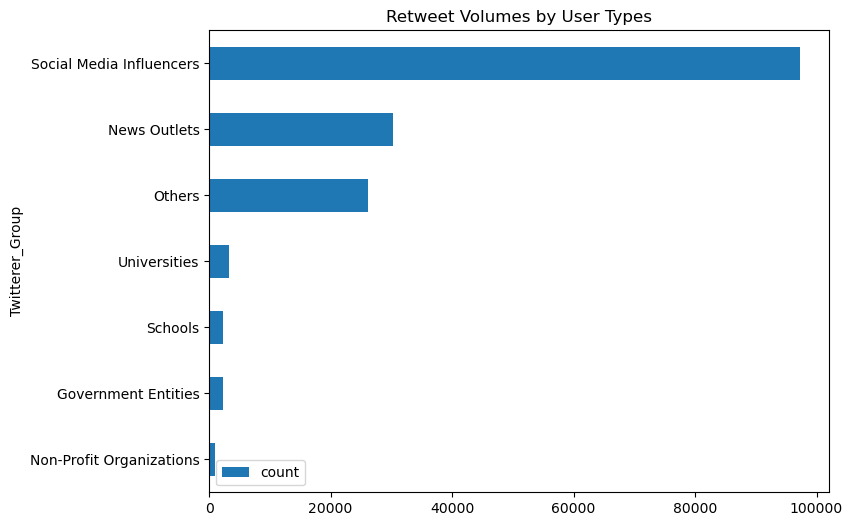

In [51]:
retwt_group_plot.plot(kind='barh', x='Twitterer_Group', y='count', figsize=(8,6),title="Retweet Volumes by User Types")

In [ ]:
# Retweets by Tweeterers and types of Orgs

retwt_user_type = verified_group.filter(col('retweeted')=='RT')\
                        .groupBy('id_str','retweeted_from','Twitterer_Group')\
                        .agg(sum('retweeted_status.retweet_count').alias('Total_Retweets'))\
                        .orderBy('Total_Retweets',ascending = False)
retwt_user_type.limit(10).toPandas()

,id_str,retweeted_from,Twitterer_Group,Total_Retweets
0,3317348164,NasimiShabnam,Social Media Influencers,440007
1,259725229,ValaAfshar,Social Media Influencers,206303
2,259725229,MichaelWarbur17,Social Media Influencers,159776
3,61109238,ProfFeynman,Social Media Influencers,118004
4,17787164,neiltyson,Social Media Influencers,115117
5,1276140426,DeAngelisCorey,Social Media Influencers,110091
6,322010071,stephyj725,News Outlets,104502
7,76564891,stephyj725,Social Media Influencers,104392
8,7434902,stephyj725,Social Media Influencers,103793
9,20227945,stephyj725,Others,103787


In [ ]:
retweet_df = retwt_user_type.join(followers_df, 'id_str', how = 'inner')
retweet_df.limit(10)

#### Where are these Twitterers (all of them, not just influencers) located?

* Any relationship between the emergence of new issues in education and progression and locations of these Twitterers?
* Visualize the geographical distribution

In [7]:
# Table: top 5 countries
location_twt = twt_newdf.filter(col('country').isNotNull())\
         .groupBy('country').count().orderBy(col('count').desc())
location_twt.limit(10).toPandas()

,country,count
0,United States,114245
1,United Kingdom,13307
2,India,12335
3,Kingdom of Saudi Arabia,8985
4,Canada,4881
5,Nigeria,3638
6,المملكة العربية السعودية,2069
7,Australia,1951
8,Pakistan,1784
9,Kenya,1644


In [53]:
# Table: top cities
twt_newdf.filter(col('country').isNotNull())\
         .groupBy('full_name').count().orderBy(col('count').desc()).limit(10).toPandas()

,full_name,count
0,"Riyadh, Kingdom of Saudi Arabia",8852
1,"Houston, TX",2108
2,"Los Angeles, CA",2107
3,"Florida, USA",2088
4,"الرياض, المملكة العربية السعودية",2037
5,"Texas, USA",1821
6,"Georgia, USA",1706
7,"Manhattan, NY",1658
8,"Chicago, IL",1499
9,"New Delhi, India",1251


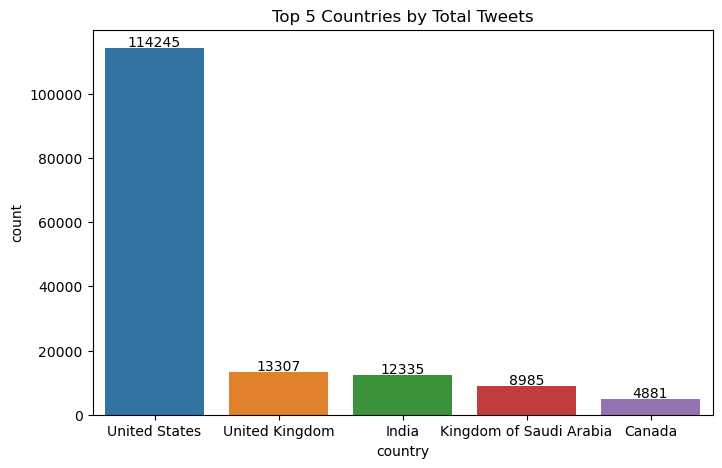

In [70]:
#location_twt_plot = location_twt.limit(5).toPandas()
plt.figure(figsize=(8,5))
ax = sns.barplot(data=location_twt_plot,x='country',y='count')
ax.set(title="Top 5 Countries by Total Tweets")
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()+1), 
                   ha = 'center', va = 'center', 
                   xytext = (0,4), 
                   textcoords = 'offset points')

In [ ]:
latlong = twt_newdf.filter(col('bounding_box').isNotNull()).select(col('bounding_box').coordinates[0][0].alias('coords')).toPandas()

In [10]:
latlong

,coords
0,"[31.208606, 30.576979]"
1,"[-88.399452, 42.168411]"
2,"[144.593742, -38.433859]"
3,"[-0.21607, 51.509879]"
4,"[30.804771, -30.127635]"
...,...
181655,"[-80.248423, 43.050553]"
181656,"[-80.260185, 25.845593]"
181657,"[-82.21201, 33.338854]"
181658,"[-2.033651, 52.381063]"


In [11]:
# Retrieve the latitude & longitude
latlong['longitude'] = latlong.coords.str[0]
latlong['latitude'] = latlong.coords.str[1]

In [12]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/miniconda3/share/proj failed


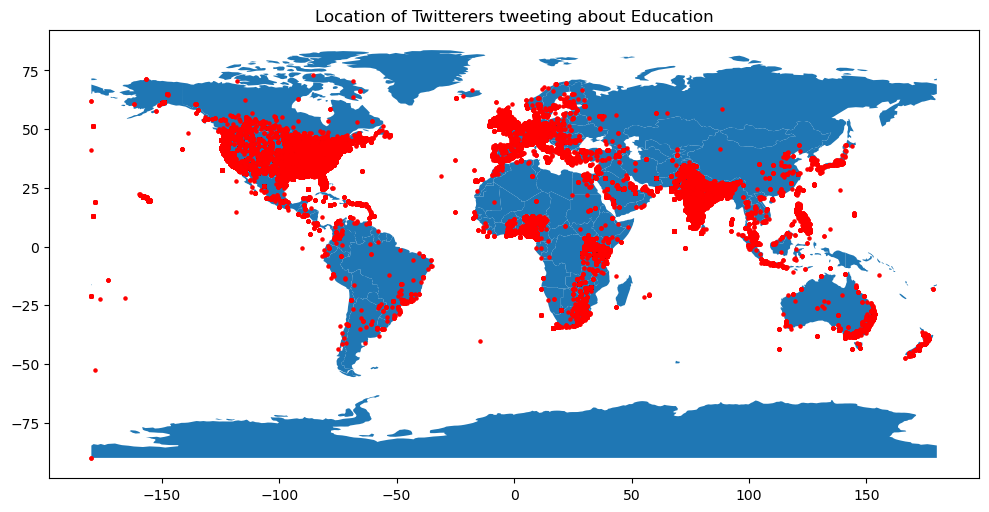

In [13]:
geometry = [Point(xy) for xy in zip(latlong['longitude'], latlong['latitude'])]
geo_df = GeoDataFrame(latlong, geometry = geometry)

# map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geo_df.plot(ax=world.plot(figsize=(12,8)), marker='o', color='red', markersize=5)
plt.title("Location of Twitterers tweeting about Education")
plt.show()

In [ ]:
# Education hot topic by locations
df_edutopic = twt_newdf.filter(col('bounding_box').isNotNull() & (
                        lower(col('text')).contains('book ban') | lower(col('text')).contains('banned book') |
                        lower(col('text')).contains('college loan') | lower(col('text')).contains('student loan')))
df_edutopic.count()

510

In [27]:
latlong2 = df_edutopic.select(col('bounding_box').coordinates[0][0].alias('coords')).toPandas()
latlong2['longitude'] = latlong2.coords.str[0]
latlong2['latitude'] = latlong2.coords.str[1]

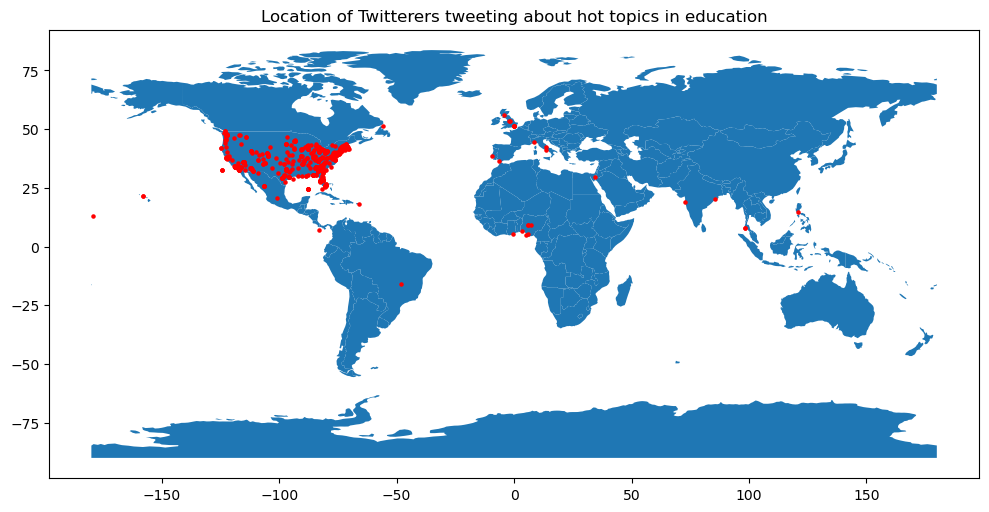

In [28]:
geometry = [Point(xy) for xy in zip(latlong2['longitude'], latlong2['latitude'])]
geo_df2 = GeoDataFrame(latlong2, geometry = geometry)

world2 = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geo_df2.plot(ax=world2.plot(figsize=(12,8)), marker='o', color='red', markersize=5)
plt.title("Location of Twitterers tweeting about hot topics in education")
plt.show()

In [ ]:
topic_location = df_edutopic.filter(col('bounding_box').isNotNull())\
         .groupBy('country').count().orderBy(col('count').desc())
topic_location.limit(10).toPandas()

,country,count
0,United States,476
1,United Kingdom,8
2,Nigeria,6
3,Canada,4
4,Italy,2
5,Thailand,2
6,India,2
7,Vereinigte Staaten,1
8,Israel,1
9,Spain,1


#### What are the timelines of these tweets? Do you see significant peaks and valleys?

Do you see any data collection gaps? 
Plot the timelines of these tweets

In [8]:
from pyspark.sql.functions import date_format, to_timestamp, unix_timestamp, from_unixtime
from pyspark.sql.functions import split

In [9]:
twt_time = twt_newdf.filter(col('country').isNotNull() & col('created_at').isNotNull()).groupBy('created_at').count().orderBy(col('count').desc())
twt_time.limit(10).toPandas()

,created_at,count
0,Tue Apr 02 06:29:42 +0000 2019,215
1,Sun Nov 25 11:20:32 +0000 2012,201
2,Mon Jul 20 07:28:49 +0000 2009,177
3,Thu Dec 18 15:48:51 +0000 2014,166
4,Wed May 16 17:57:16 +0000 2012,150
5,Tue Nov 10 01:06:12 +0000 2020,142
6,Thu Nov 08 07:44:56 +0000 2018,118
7,Fri Apr 26 01:01:16 +0000 2019,117
8,Fri Oct 24 02:23:04 +0000 2008,105
9,Thu Jun 21 21:51:05 +0000 2012,97


In [24]:
# tweet_time2 = twt_time.withColumn('created_time', from_unixtime(unix_timestamp(col('created_at'), 'EEE MMM dd HH:mm:ss ZZZZ yyyy')))

In [11]:
twt_time2.head()

,created_at,count
0,Tue Apr 02 06:29:42 +0000 2019,215
1,Sun Nov 25 11:20:32 +0000 2012,201
2,Mon Jul 20 07:28:49 +0000 2009,177
3,Thu Dec 18 15:48:51 +0000 2014,166
4,Wed May 16 17:57:16 +0000 2012,150


In [14]:
twt_time2['created_time'] = pd.to_datetime(twt_time2["created_at"], errors='coerce')
twt_time2

,created_at,count,created_time
0,Tue Apr 02 06:29:42 +0000 2019,215,2019-04-02 06:29:42+00:00
1,Sun Nov 25 11:20:32 +0000 2012,201,2012-11-25 11:20:32+00:00
2,Mon Jul 20 07:28:49 +0000 2009,177,2009-07-20 07:28:49+00:00
3,Thu Dec 18 15:48:51 +0000 2014,166,2014-12-18 15:48:51+00:00
4,Wed May 16 17:57:16 +0000 2012,150,2012-05-16 17:57:16+00:00
...,...,...,...
114525,Sun Sep 25 01:52:09 +0000 2016,1,2016-09-25 01:52:09+00:00
114526,Sat Aug 28 17:28:50 +0000 2010,1,2010-08-28 17:28:50+00:00
114527,Tue Sep 13 03:58:34 +0000 2011,1,2011-09-13 03:58:34+00:00
114528,Fri Dec 29 21:50:00 +0000 2017,1,2017-12-29 21:50:00+00:00


In [16]:
twt_time2['hour'] = twt_time2["created_time"].dt.hour
twt_by_hour = twt_time2.groupby('hour')['count'].sum()
twt_by_hour

hour
0      8271
1      8787
2      9097
3      7847
4      7042
5      5638
6      5432
7      4653
8      4105
9      4054
10     4508
11     5161
12     5674
13     7398
14     8880
15     9792
16     9398
17    10075
18    10066
19    10072
20     9739
21     9283
22     8626
23     8063
Name: count, dtype: int64

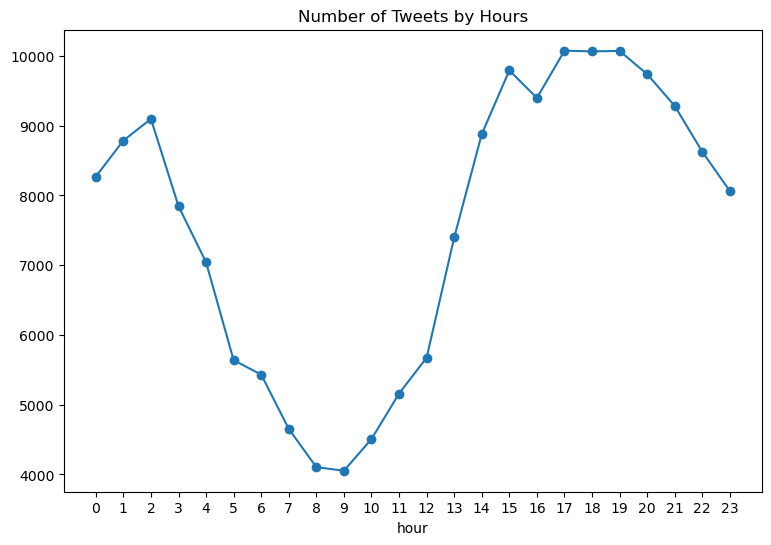

In [28]:
twt_by_hour_plot = twt_by_hour.reset_index(name='count')
ax = twt_by_hour_plot.plot(kind='line', x='hour', y='count', legend=None, marker='o',figsize=(9,6), title = 'Number of Tweets by Hours')
ax.set_xticks(twt_by_hour_plot['hour'])
plt.show()

In [27]:
twt_time2['weekday'] = pd.to_datetime(twt_time2['created_at']).dt.day_name()
twt_time2

,created_at,count,created_time,hour,weekday
0,Tue Apr 02 06:29:42 +0000 2019,215,2019-04-02 06:29:42+00:00,6,Tuesday
1,Sun Nov 25 11:20:32 +0000 2012,201,2012-11-25 11:20:32+00:00,11,Sunday
2,Mon Jul 20 07:28:49 +0000 2009,177,2009-07-20 07:28:49+00:00,7,Monday
3,Thu Dec 18 15:48:51 +0000 2014,166,2014-12-18 15:48:51+00:00,15,Thursday
4,Wed May 16 17:57:16 +0000 2012,150,2012-05-16 17:57:16+00:00,17,Wednesday
...,...,...,...,...,...
114525,Sun Sep 25 01:52:09 +0000 2016,1,2016-09-25 01:52:09+00:00,1,Sunday
114526,Sat Aug 28 17:28:50 +0000 2010,1,2010-08-28 17:28:50+00:00,17,Saturday
114527,Tue Sep 13 03:58:34 +0000 2011,1,2011-09-13 03:58:34+00:00,3,Tuesday
114528,Fri Dec 29 21:50:00 +0000 2017,1,2017-12-29 21:50:00+00:00,21,Friday


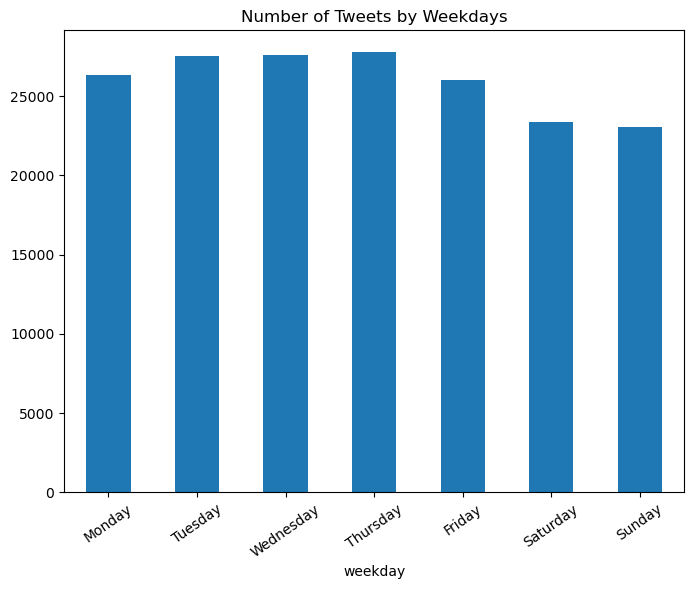

In [62]:
twt_by_weekday = twt_time2.groupby('weekday')['count'].sum()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reindex the DataFrame based on weekday_order list
twt_by_weekday = twt_by_weekday.reindex(weekday_order)

twt_by_weekday_plot = twt_by_weekday.reset_index(name='count')
ax = twt_by_weekday_plot.plot(kind='bar', x='weekday', y='count', legend=None, figsize=(8,6), title = 'Number of Tweets by Weekdays')
plt.xticks(rotation=35)
plt.show()

In [13]:
tweet_time2 = tweet_time.withColumn("weekday",from_unixtime(unix_timestamp(col("date_of_week"),'EEE'),'EE'))\
                        .withColumn("month",from_unixtime(unix_timestamp(col("month"),'MMM'),'MM'))\
                        .withColumn("date",from_unixtime(unix_timestamp(col("date_of_week"),'dd'),'dd'))\
                        .withColumn("year",from_unixtime(unix_timestamp(col("date_of_week"),'yyyy'),'yyyy'))

In [ ]:
tweet_time2.limit(10)